In [1]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
from brainlit.utils.Neuron_trace import NeuronTrace
from mpl_toolkits.mplot3d import Axes3D
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from scipy.interpolate import splev
from brainlit.algorithms.trace_analysis.spline_fxns import curvature, torsion

/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


# Define brain, neuron, and data folders

In [2]:
#specify brain1 or brain2 below
brain = "brain1"
seg_id = 2
string_id = str(seg_id).zfill(3)

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
seg_swc_path = os.path.join(
    segments_swc_dir,
    "{}_g-{}_consensus.swc".format(
        "2018-08-01" if brain == "brain1" else "2018-12-01", string_id
    ),
)
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /cis/home/jteneggi/repo/brainlit/experiments/axon_geometry/data/brain1/segments_swc


# Load and fit neuron

In [3]:
swc_trace = NeuronTrace(path=seg_swc_path)
df_swc_offset_neuron = swc_trace.get_df()

print("Loaded segment {}".format(seg_id))
G = GeometricGraph(df=df_swc_offset_neuron)
spline_tree = G.fit_spline_tree_invariant()

Loaded segment 2


# Plot B-spline fit

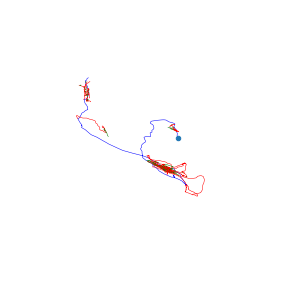

In [4]:
def node_height(G, node):
    predecessors = list(G.predecessors(node))
    L = len(predecessors)
    assert L == 1 or L == 0
    if L == 0:
        return 0
    else:
        return 1 + node_height(G, predecessors[0])

fig = plt.figure()
ax = Axes3D(fig)

for j, node in enumerate(spline_tree.nodes):
    spline = spline_tree.nodes[node]
    spline_height = node_height(spline_tree, node)
    tck, u_um = spline["spline"]
    y = splev(np.arange(u_um[0],u_um[-1], 0.1), tck)

    if spline_height == 0:
        c = "b"
        ax.scatter(y[0][0],y[1][0],y[2][0],'b')
    else:
        successors = spline_tree.successors(node)
        if len(list(successors)) == 0:
            c = "g"
        else:
            c = "r"

    ax.plot(y[0], y[1], y[2], c, linewidth=0.5)

ax.set_axis_off()

# Evaluate curvature and torsion

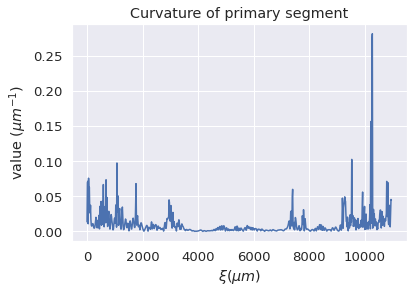

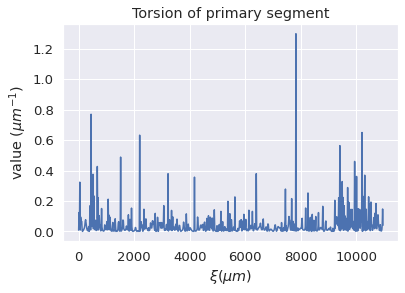

Text(0.5, 1.0, 'Mean curvature and torsion for all segments')

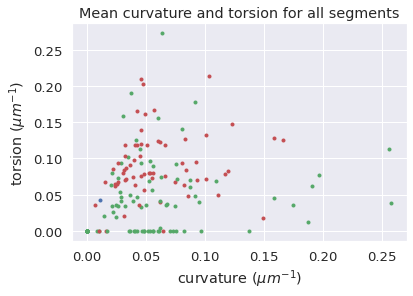

In [7]:
import seaborn as sns

sns.set_theme()
sns.set_context("paper")
sns.set(font_scale=1.2)

classes = []
curvatures = []
torsions = []

spacing = 14
for j, node in enumerate(spline_tree.nodes):
    if j == 0:
        main_branch = spline_tree.nodes[node]
    spline = spline_tree.nodes[node]
    spline_height = node_height(spline_tree, node)
    if spline_height == 0:
        spline_class = "primary"
    else:
        successors = spline_tree.successors(node)
        if len(list(successors)) == 0:
            spline_class = "terminal"
        else:
            spline_class = "collateral"
    starting_length = spline["starting_length"]
    path = spline["path"]
    tck, u_um = spline["spline"]
    t = tck[0]
    c = tck[1]
    k = tck[2]

    # evaluate segment length (in um)
    seg_length = u_um[-1] - u_um[0]
    # resample points at specified spacing
    uu = np.arange(u_um[0], u_um[-1], spacing)
    # evaluate mean curvature of the segment
    _curvature = curvature(uu, t, c, k)
    mean_curvature = np.mean(_curvature)
    # evaluate mean torsion of the segment
    _torsion = np.abs(torsion(uu, t, c, k))
    mean_torsion = np.mean(_torsion)
    
    classes.append(spline_class)
    curvatures.append(mean_curvature)
    torsions.append(mean_torsion)
        
    if spline_height == 0:
        plt.plot(uu, _curvature, label="curvature")
        plt.xlabel(r"$\xi (\mu m)$")
        plt.ylabel(r"value ($\mu m^{-1}$)")
        plt.title("Curvature of primary segment")
        plt.show()
        plt.plot(uu, _torsion, label="torsion")
        plt.xlabel(r"$\xi (\mu m)$")
        plt.ylabel(r"value ($\mu m^{-1}$)")
        plt.title("Torsion of primary segment")
        plt.show()

for _class, _curvature, _torsion in zip(classes, curvatures, torsions):
    if _class == "primary":
        c = "b"
    elif _class == "collateral":
        c = "r"
    elif _class == "terminal":
        c = "g"
    plt.scatter(_curvature, _torsion, marker=".", c=c)
plt.xlabel(r"curvature ($\mu m^{-1}$)")
plt.ylabel(r"torsion ($\mu m^{-1}$)")
plt.title("Mean curvature and torsion for all segments")